<a href="https://colab.research.google.com/github/monicaneli/Sistema_de_Recomendacao_por_Imagens/blob/main/Sistema_de_Recomendacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sistema de Recomendação baseado em similaridade visual

Este projeto tem como objetivo desenvolver um Sistema de Recomendação baseado em similaridade visual de imagens, utilizando redes de Deep Learning e técnicas de busca em espaço vetorial.

A proposta é permitir que, a partir da imagem de um produto (ex.: cadeira, bicicleta, caneca), o sistema sugira itens visualmente semelhantes em termos de forma, cor e textura.

O projeto demonstra a viabilidade de um motor de recomendação por imagem, aplicável a e-commerces, catálogos digitais e sistemas de busca visual, proporcionando uma experiência de compra mais intuitiva e personalizada.

- Para a prova de conceito, foi utilizado o **Stanford Online Products Dataset**, um conjunto de mais de 120 mil imagens organizadas por categorias de produtos.

- A extração de características visuais foi realizada com uma rede **ResNet50 pré-treinada no ImageNet**, onde os embeddings (representações vetoriais das imagens) são gerados a partir da penúltima camada da rede.Esses vetores são então indexados em um mecanismo de busca baseado no **FAISS (Facebook AI Similarity Search)**, que possibilita encontrar rapidamente os produtos mais semelhantes a uma consulta.

O sistema utiliza *transfer learning*, aproveitando uma rede pré-treinada (ResNet50) para extrair embeddings das imagens, evitando treinar do zero.

O fluxo do sistema consiste em:

1. **Pré-processamento** das imagens do dataset.
2. **Extração de embeddings** com CNN pré-treinada.
3. **Indexação dos vetores** em FAISS.
4. **Consulta e recomendação**, retornando produtos similares à imagem fornecida.









In [6]:
# Instalações e Imports
!pip install faiss-cpu
#!pip install faiss-gpu faiss-cpu
import numpy as np
import matplotlib.pyplot as plt
import faiss
import glob
import os

from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 30.6 MB/s eta 0:00:00


In [23]:
# Funções

#Função para extrair embeddings
def get_embedding(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = resnet50.preprocess_input(x)
    embedding = model.predict(x)
    return embedding / np.linalg.norm(embedding)  # normalizar


#Função de recomendação
def recommend(img_path, k=3):
    query_emb = get_embedding(img_path).astype("float32")
    D, I = index.search(query_emb, k)  # D = distâncias, I = índices
    print("Imagens mais similares para:", img_path)

    # Mostrar resultados
    plt.figure(figsize=(10, 4))
    plt.subplot(1, k+1, 1)
    plt.imshow(image.load_img(img_path))
    plt.title("Consulta")
    plt.axis("off")

    for i, idx in enumerate(I[0]):
        plt.subplot(1, k+1, i+2)
        plt.imshow(image.load_img(image_paths[idx]))
        plt.title(f"Similar {i+1}")
        plt.axis("off")
    plt.show()



## Base de dados Stanford Online Products Dataset

Para a prova de conceito, foram selecionadas as categorias **bicycle, chair, lamp, mug e sofa**, de modo a contemplar diferentes tipos de produtos do dataset Stanford Online Products.

A fim de manter o projeto leve e compatível com os recursos gratuitos do Google Colab, foi utilizado um subconjunto limitado a no máximo 200 imagens por categoria, garantindo diversidade visual sem comprometer a eficiência do processamento e da indexação.

In [2]:
# Base de dados
!gdown 1TclrpQOF_ullUP99wk_gjGN8pKvtErG8 -O Stanford_Online_Products.zip
!unzip Stanford_Online_Products.zip
rm -rf Stanford_Online_Products.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/Stanford_Products/Stanford_Online_Products/mug_final/391217829475_4.JPG  
  inflating: /content/Stanford_Products/Stanford_Online_Products/mug_final/271927317253_2.JPG  
  inflating: /content/Stanford_Products/Stanford_Online_Products/mug_final/391018865779_5.JPG  
  inflating: /content/Stanford_Products/Stanford_Online_Products/mug_final/161559270421_5.JPG  
  inflating: /content/Stanford_Products/Stanford_Online_Products/mug_final/171808572954_2.JPG  
  inflating: /content/Stanford_Products/Stanford_Online_Products/mug_final/231456834036_2.JPG  
  inflating: /content/Stanford_Products/Stanford_Online_Products/mug_final/301593961236_6.JPG  
  inflating: /content/Stanford_Products/Stanford_Online_Products/mug_final/281765898130_0.JPG  
  inflating: /content/Stanford_Products/Stanford_Online_Products/mug_final/271936543624_2.JPG  
  inflating: /content/Stanford_Products/Stanford_Online_Products/mug_final/32

In [14]:
# Preparar o dataset

# Pegar algumas categorias
categories = ["bicycle_final", "chair_final", "lamp_final", "mug_final", "sofa_final"]

base_path = "/content/Stanford_Products/Stanford_Online_Products/"
image_paths = []
labels = []

for cat in categories:
    files = glob.glob(os.path.join(base_path, cat, "*.*"))
    files = [f for f in files if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    image_paths.extend(files[:200])  # limitar para não estourar memória
    labels.extend([cat] * len(files[:200]))

print("Total de imagens carregadas:", len(image_paths))
#print("Exemplo:", image_paths[:3])

Total de imagens carregadas: 1000
Exemplo: ['/content/Stanford_Products/Stanford_Online_Products/bicycle_final/361352349402_2.JPG', '/content/Stanford_Products/Stanford_Online_Products/bicycle_final/151709187034_4.JPG', '/content/Stanford_Products/Stanford_Online_Products/bicycle_final/390562919431_5.JPG']


In [17]:
# Imagens de teste
!wget -O mug.jpg "https://github.com/monicaneli/Sistema_de_Recomendacao_por_Imagens/raw/032a3f7da37068466fc9799f9622a4c41bf93434/pexels-pixabay-50676.jpg"
!wget -O sofa.jpg "https://github.com/monicaneli/Sistema_de_Recomendacao_por_Imagens/raw/032a3f7da37068466fc9799f9622a4c41bf93434/pexels-heyho-8135260.jpg"
!wget -O lamp.jpg "https://github.com/monicaneli/Sistema_de_Recomendacao_por_Imagens/raw/032a3f7da37068466fc9799f9622a4c41bf93434/pexels-446120723-15524191.jpg"

--2025-09-16 00:03:48--  https://github.com/monicaneli/Sistema_de_Recomendacao_por_Imagens/raw/032a3f7da37068466fc9799f9622a4c41bf93434/pexels-pixabay-50676.jpg
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/monicaneli/Sistema_de_Recomendacao_por_Imagens/032a3f7da37068466fc9799f9622a4c41bf93434/pexels-pixabay-50676.jpg [following]
--2025-09-16 00:03:49--  https://raw.githubusercontent.com/monicaneli/Sistema_de_Recomendacao_por_Imagens/032a3f7da37068466fc9799f9622a4c41bf93434/pexels-pixabay-50676.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19052 (19K) [image/jpeg]
Saving to: ‘mug.jpg’

m

In [8]:
# Carregar modelo pré-treinado (sem a última camada)
# Base: ResNet50 treinada no ImageNet
base_model = resnet50.ResNet50(weights="imagenet", include_top=True)
# Usar a penúltima camada (embeddings de 2048 dimensões)
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)


102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [15]:
# Extrair embeddings e indexar com FAISS

# Criar matriz de embeddings
embeddings = []
for path in image_paths:
    emb = get_embedding(path)
    embeddings.append(emb)

embeddings = np.vstack(embeddings).astype("float32")

# Criar índice FAISS
d = embeddings.shape[1]  # dimensão do vetor
index = faiss.IndexFlatL2(d)  # distância euclidiana
index.add(embeddings)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

## Recomendando produtos


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
Imagens mais similares para: /content/mug.jpg


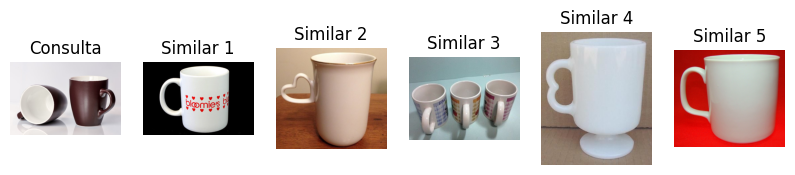

In [24]:
recommend("/content/mug.jpg", k=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
Imagens mais similares para: /content/sofa.jpg


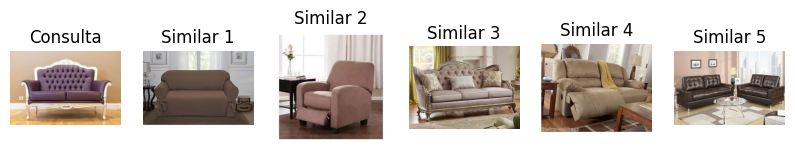

In [25]:
recommend("/content/sofa.jpg", k=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
Imagens mais similares para: /content/lamp.jpg


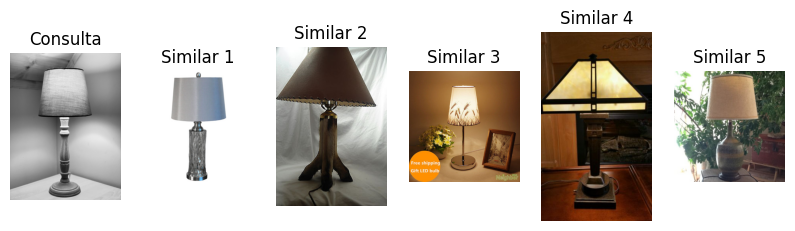

In [26]:
recommend("/content/lamp.jpg", k=5)

## Referências

[1] Stanford Online Products dataset ([Descrição no GitHub](https://github.com/rksltnl/Deep-Metric-Learning-CVPR16))

[2] Imagens obtidas do [Pexels](https://www.pexels.com/)

[3] Similar Product Recommendations ([no GitHub](https://github.com/sparsh-ai/rec-tutorials/blob/master/_notebooks/2021-04-27-image-similarity-recommendations.ipynb))

